# ML1 Project: Predicting Political Ideology from Economic Indicators

## Table of Contents
* [Introduction](#introduction)
* [Dataset Overview & Requirements](#dataset)
* [Data Cleaning & Preparation](#cleaning)
* [Exploratory Data Analysis (EDA)](#eda)
* [Feature Engineering](#features)
* [Modeling](#modeling)
    * [Linear Model (LM)](#lm)
    * [Generalized Linear Model (GLM) - Poisson/Binomial](#glm)
    * [Generalized Additive Model (GAM)](#gam)
    * [Neural Network (NN)](#nn)
    * [Support Vector Machine (SVM)](#svm)
    * [Non-linear LM/GAM Baseline](#nonlinear)
* [Model Evaluation & Residual Analysis](#evaluation)
* [Conclusions & Recommendations](#conclusions)
* [AI Usage Reflection](#aiusage)
* [Team Contributions](#roles)

---

## <a id='Introduction'></a>1. Introduction

### Objective

The objective of this analysis is to examine whether a country’s dominant political ideology – categorized as left, center, or right – can be predicted from its economic indicators. We also explore how economic metrics (e.g. growth, trade, military spending) correlate with shifts in political ideology or election outcomes, and whether countries cluster into profiles with similar economic-political characteristics. Rickardsson,2021 suggests that there is a divide between urban and rural populations for voting characteristics. Possibly because of lower access to public services in rural areas, they respond to the deterioration of their location by casting a vote on the far-right. Economic voting phenomena suggests that, voters hold the major incumbent party accountable for recent economic performance while voting. In addition, recent research shows that higher levels of GDP in a country result in greater far-right preference (Lucassen &  Lubbers ,2011). In authoritarian regimes, military spending tends to be higher than in democratic regimes while right-wing governments spend more on arms purchases and left-wing governments spend more on military personnel (Carter,2016). In the light of these findings, we wanted to explore the relationship between leader ideologies, economic indicators, military spending and urban population counts using predictive modeling.

The project involves assembling data from multiple sources, conducting thorough exploratory data analysis (EDA), building predictive models, and interpreting key drivers, all compiled into a client-ready report. Below, we present the process and findings in a structured manner.

### Research Questions
1. Are economic indicators related to selected leader ideologies?
2. Can we predict military spending from leader ideologies and other economic indicators?
3. Is there a relationship between urban population counts with leader ideologies and other economic indicators?

### Definitions 

| 🔴 Left | 🟡 Centrist | 🔵 Right |
| --- | --- | --- |
| Left politics: Fair share for all, strong public services, government intervention to reduce inequality.<br>**Examples:** Venezuela, Bolivia, Cuba | Centrist politics: Compromise, pragmatic, balances both state and market.<br>**Examples:** Germany, Canada, Chile | Right politics: Free markets, less government, individual responsibility.<br>**Examples:** USA, UK, Australia |

In [188]:
# Imports (deduplicated and grouped)
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    r2_score,
    roc_auc_score,
    roc_curve,
    auc,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

## <a id='dataset'></a>2 Dataset Overview & Requirements

Data Sources: We worked with three datasets provided in ML1-HSLU-main.zip:
- **Global Economy Indicators** – Annual economic data for countries, e.g. GDP, GNI, sector outputs, trade. (annual, 200+ countries, ≈1970–2021, 26 indicators) 
- **Global Leader Ideologies** – Yearly classification of each country’s head-of-government ideology (left/center/right) from 1945–2020.
- **Military Spending** – Country-level military expenditure as % of GDP (World Bank indicator). from
- **Rural/Urban Population** - Unemployment (%) and population (count)  data from

### Requirements
- **Size:** 2,000+ observations (1990–2020, 266 countries)
- **Predictors:** 15+ features, including GDP, GNI, population, urban/rural counts, military spending
- **Variable Types:**
    - Continuous: GDP, GNI, etc.
    - Categorical: Leader ideology (left/center/right), democracy (yes/no)
    - Count: Urban and rural population
    - Binary: Democracy
    - Categorical >2 levels: Leader ideology 
- **Originality:** Data sourced from World Bank and specialized political datasets (not Kaggle).

# 🚩
## 3. Data and Cleaning 
- **Goal:** Prepare a unified dataset for modeling, ensuring columns are clean, types are correct, and all 'amount' variables are log-transformed.


| Step | What we did |
| --- | --- |
| **1. Extraction & First Look** | We unzipped every file and read them into data frames. The economy file holds 26 indicators for 200 + countries (≈ 1970 – 2021).<br>The ideology file tags leaders in ~180 countries (1945 – 2020). The military file tracks defence spending for ~260 entities (1960 – 2023).<br>We saw each file used different country codes, so a common key was needed. |
| **2. Trimming & Encoding** | We stripped extra spaces (e.g., “ Afghanistan ” → “Afghanistan”) and fixed text encoding so names line up. |
| **3. Country Name Match-up** | We built a mapping to bring names in line.<br>Examples:<br>• “United States” → “United States of America”<br>• “Bolivia (Plurinational State of)” → “Bolivia”<br>• Merged old entries like “Yemen Arab Republic (Former)” into today’s names. |
| **4. Handling Missing Values** | Ideology rows labelled “no information” were dropped, so the model sees only clear left / center / right tags. |
| **5. Wide → Long Reshape** | The military data was pivoted from wide to long, giving one row per country-year. |
| **6. Final Merge & Clean-up** | Using aligned country names and year, we joined all three sets. The final frame covers 1990 – 2020, ~2 897 rows, 266 countries, 25 columns that include:<br>• Economic stats (GDP, GNI, sectors, trade)<br>• Military spend (% GDP)<br>• Leader ideology, democracy flag, gov-leader match, region<br>• Urban & rural populations.<br>Rows with key gaps were dropped so models get complete cases. |

We confirmed that key variables like GDP and GNI are in units (economy data indicated GNI in USD), rows with incomplete features and missing data were dropped for modeling to ensure algorithms receive complete cases.

> **Note:** This notebook uses a pre-merged, cleaned CSV: `new_data_with_count.csv` for simplicity.



In [189]:
# Data loading and consolidated cleaning
data = pd.read_csv("new_data_with_count.csv")
# Clean column names and rename key columns only once
data.rename(columns={
    'Gross.National.Income.GNI..in.USD': 'gross_national_income_GNI',
    'Military.expenditure....of.GDP.': 'military_expenditure',
    'Gross.Domestic.Product..GDP.': 'GDP'
}, inplace=True)
data.columns = data.columns.str.replace('.', '_', regex=False)
# Filter for valid ideologies in both columns in one step
valid_ideologies = ["leftist", "rightist", "centrist"]
data = data[data["leader_ideology"].isin(valid_ideologies) & data["hog_ideology"].isin(valid_ideologies)]
# Drop missing values once, after all cleaning
data = data.dropna()
print('Data shape after cleaning:', data.shape)
data.head()

Data shape after cleaning: (2839, 26)


,Unnamed: 0,Country,Year,hog_ideology,leader_ideology,match_hog_leader,democracy,region,IMF_based_exchange_rate,Population,...,Gross_capital_formation,Imports_of_goods_and_services,mining_manifacturing_isic,transport_storage_communication_isic,wholesale_trade_restaurant_hotel_isic,gross_national_income_GNI,GDP,military_expenditure,Urban_population,Rural_population
0,1,Albania,1990,leftist,leftist,yes,no,Eastern Europe and Central Asia,7.745833,3295066.0,...,543166947.0,4.828841e+08,863176680.0,29857978.0,139120369.0,2.143811e+09,2.145751e+09,5.888301,1197222.0,2089320.0
1,2,Albania,1996,rightist,rightist,no,no,Eastern Europe and Central Asia,104.498917,3271331.0,...,450950921.0,1.158532e+09,328096576.0,114349551.0,625299293.0,3.271327e+09,3.199642e+09,1.379030,1250518.0,1917515.0
2,3,Albania,1997,leftist,leftist,yes,no,Eastern Europe and Central Asia,148.932917,3253719.0,...,379550276.0,8.673393e+08,207636030.0,102111606.0,439101205.0,2.274234e+09,2.224654e+09,1.283081,1260414.0,1887867.0
3,4,Albania,1998,leftist,leftist,yes,no,Eastern Europe and Central Asia,150.633333,3232175.0,...,559126614.0,1.026883e+09,209136519.0,143265871.0,497629404.0,2.631658e+09,2.554869e+09,1.238243,1270214.0,1858316.0
4,5,Albania,1999,leftist,leftist,yes,no,Eastern Europe and Central Asia,137.690583,3208260.0,...,782952374.0,1.204031e+09,256181697.0,198712208.0,682986473.0,3.297165e+09,3.221670e+09,1.249210,1279853.0,1828925.0


### Brief Data Overview
- Data covers years 1990–2020, ~2,800 rows, 25+ columns
- Key variables: country, year, region, ideology, GDP, GNI, sector outputs, trade, military expenditure, urban/rural population

## <a id='Exploratory-Data-Analysis'></a>4. Exploratory Data Analysis (EDA)
With a clean, merged dataset, we performed EDA to understand the distributions of variables, relationships between economic indicators and ideology, and potential multicollinearity or clustering patterns.

  
### 4.1. Summary Statistics
We first examined summary stats for the key indicators. There is wide variability in country economic profiles – e.g. population ranges from microstates under 100k to countries over 1 billion; GDP ranges several orders of magnitude. Economic metrics are highly skewed (a few very large economies drive the upper ranges), which justifies our use of log transforms for analysis. The **ideology distribution** in the data is roughly: 49% leftist, 41% rightist, and 10% centrist (counting each country-year as one observation). This indicates centrist governments are comparatively rare in the dataset, a point to keep in mind for modeling (class imbalance). We also noted potential regional patterns: for example, many Western European and North American entries are coded as center or right, whereas a number of Latin American and African country-years are coded as left (often in the context of socialist or populist leaders in certain periods). These are general trends – we will explore if the data supports them.


In [190]:
data.describe()

,Unnamed: 0,Year,IMF_based_exchange_rate,Population,Per_capita_GNI,agriculture_and_hunting_fishing_isic,Changes_in_inventories,construction_isic,Exports_of_goods_and_services,Gross_capital_formation,Imports_of_goods_and_services,mining_manifacturing_isic,transport_storage_communication_isic,wholesale_trade_restaurant_hotel_isic,gross_national_income_GNI,GDP,military_expenditure,Urban_population,Rural_population
count,2839.000000,2839.000000,2.839000e+03,2.839000e+03,2839.000000,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2.839000e+03,2839.000000,2.839000e+03,2.839000e+03
mean,1471.943642,2005.401198,3.668795e+02,4.923068e+07,11929.061994,1.706350e+10,2.795729e+09,2.626027e+10,1.180123e+11,1.218940e+11,1.177142e+11,1.033571e+11,4.250250e+10,6.741416e+10,4.915696e+11,4.918589e+11,1.883127,2.556468e+07,2.371807e+07
std,854.277457,8.768498,1.292241e+03,1.634829e+08,16712.224383,6.821488e+10,1.335536e+10,8.624088e+10,2.921032e+11,4.630354e+11,3.058433e+11,3.639012e+11,1.608563e+11,2.439226e+11,1.744509e+12,1.725458e+12,1.661059,7.260303e+07,9.843552e+07
min,1.000000,1990.000000,2.990000e-08,3.653920e+05,93.000000,1.291251e+07,-1.510000e+11,1.203692e+06,3.153309e+07,-3.661706e+07,6.077100e+07,2.556118e+07,1.196390e+07,1.809387e+07,1.518711e+08,1.651184e+08,0.142302,2.136240e+05,0.000000e+00
25%,718.500000,1998.000000,1.000000e+00,4.521495e+06,1161.500000,1.024853e+09,1.323694e+07,4.418734e+08,3.288824e+09,2.195329e+09,4.069802e+09,1.757766e+09,7.117756e+08,1.385474e+09,9.697471e+09,1.008214e+10,1.048823,2.087038e+06,1.270623e+06
50%,1483.000000,2005.000000,6.542152e+00,1.037475e+07,3912.000000,3.121847e+09,2.786248e+08,2.077536e+09,1.348912e+10,9.151849e+09,1.431356e+10,8.519366e+09,3.459299e+09,5.278352e+09,3.886868e+10,4.037793e+10,1.502214,4.835557e+06,4.119674e+06
75%,2213.500000,2013.000000,1.016631e+02,2.938625e+07,16601.500000,9.870354e+09,1.537247e+09,1.251176e+10,8.356018e+10,5.528752e+10,8.366394e+10,5.400426e+10,2.031976e+10,3.227475e+10,2.405000e+11,2.450000e+11,2.287494,1.683862e+07,1.203869e+07
max,2954.000000,2020.000000,1.458220e+04,1.424930e+09,103989.000000,1.180000e+12,2.110000e+11,1.050000e+12,2.720000e+12,6.370000e+12,3.130000e+12,4.550000e+12,2.250000e+12,3.120000e+12,2.180000e+13,2.140000e+13,48.517267,8.668105e+08,9.127394e+08


- Years: 1990–2020, confirming filter
- Urban/rural populations: balanced, some countries are highly urbanized
- Military expenditure: mean ~2% of GDP, wide range
- Most variables are highly right-skewed (see next plots)


### 4.2. Correlation Heatmap
Visualizing correlations helps us see how variables relate, and whether multicollinearity may affect modeling.

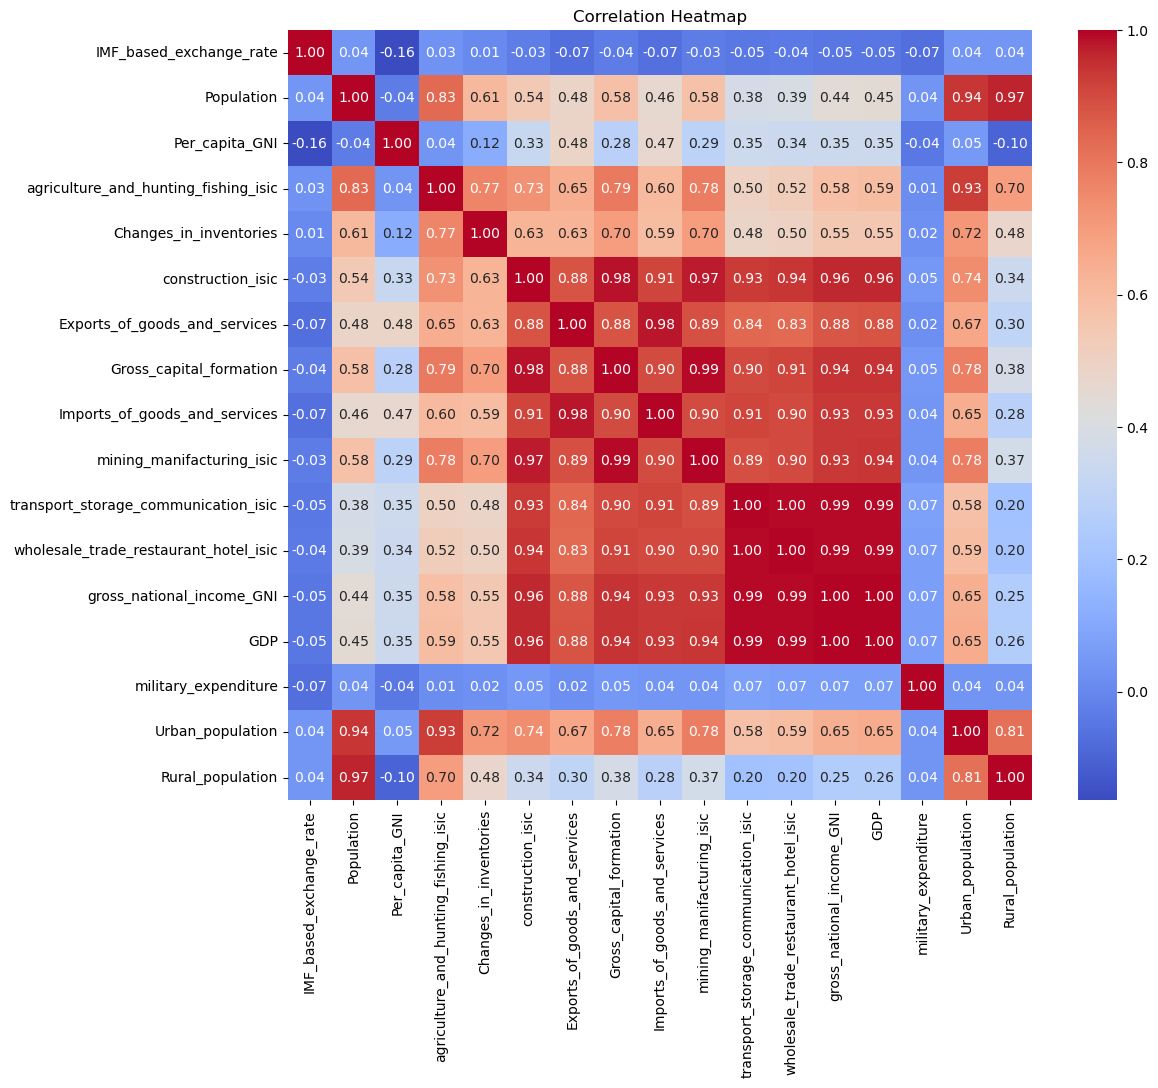

In [191]:
selected_cols = [
    'IMF_based_exchange_rate', 'Population', 'Per_capita_GNI',
    'agriculture_and_hunting_fishing_isic', 'Changes_in_inventories',
    'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation',
    'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic',
    'gross_national_income_GNI', 'GDP', 'military_expenditure',
    'Urban_population', 'Rural_population'
]
plt.figure(figsize=(12,10))
sns.heatmap(data[selected_cols].corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Some variables are strongly correlated (e.g., GDP & GNI, sector outputs)
Military expenditure, exchange rates less correlated to others
High correlations suggest need for normalization and/or dimensionality reduction


We need to define target and features because it is challenging to see how variables relate

### 4.3. Feature Selection
Let's select features for modeling based on domain knowledge and the above analysis.

In [192]:
features = [
    'IMF_based_exchange_rate', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic',
    'Changes_in_inventories', 'construction_isic', 'Exports_of_goods_and_services',
    'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic',
    'gross_national_income_GNI', 'GDP', 'Urban_population', 'Rural_population'
]
X = data[features]
y = data['leader_ideology']

# 🚩
### 4.4. Distribution Plots for Numerical Variables
Most variables are right-skewed. Let's visualize.

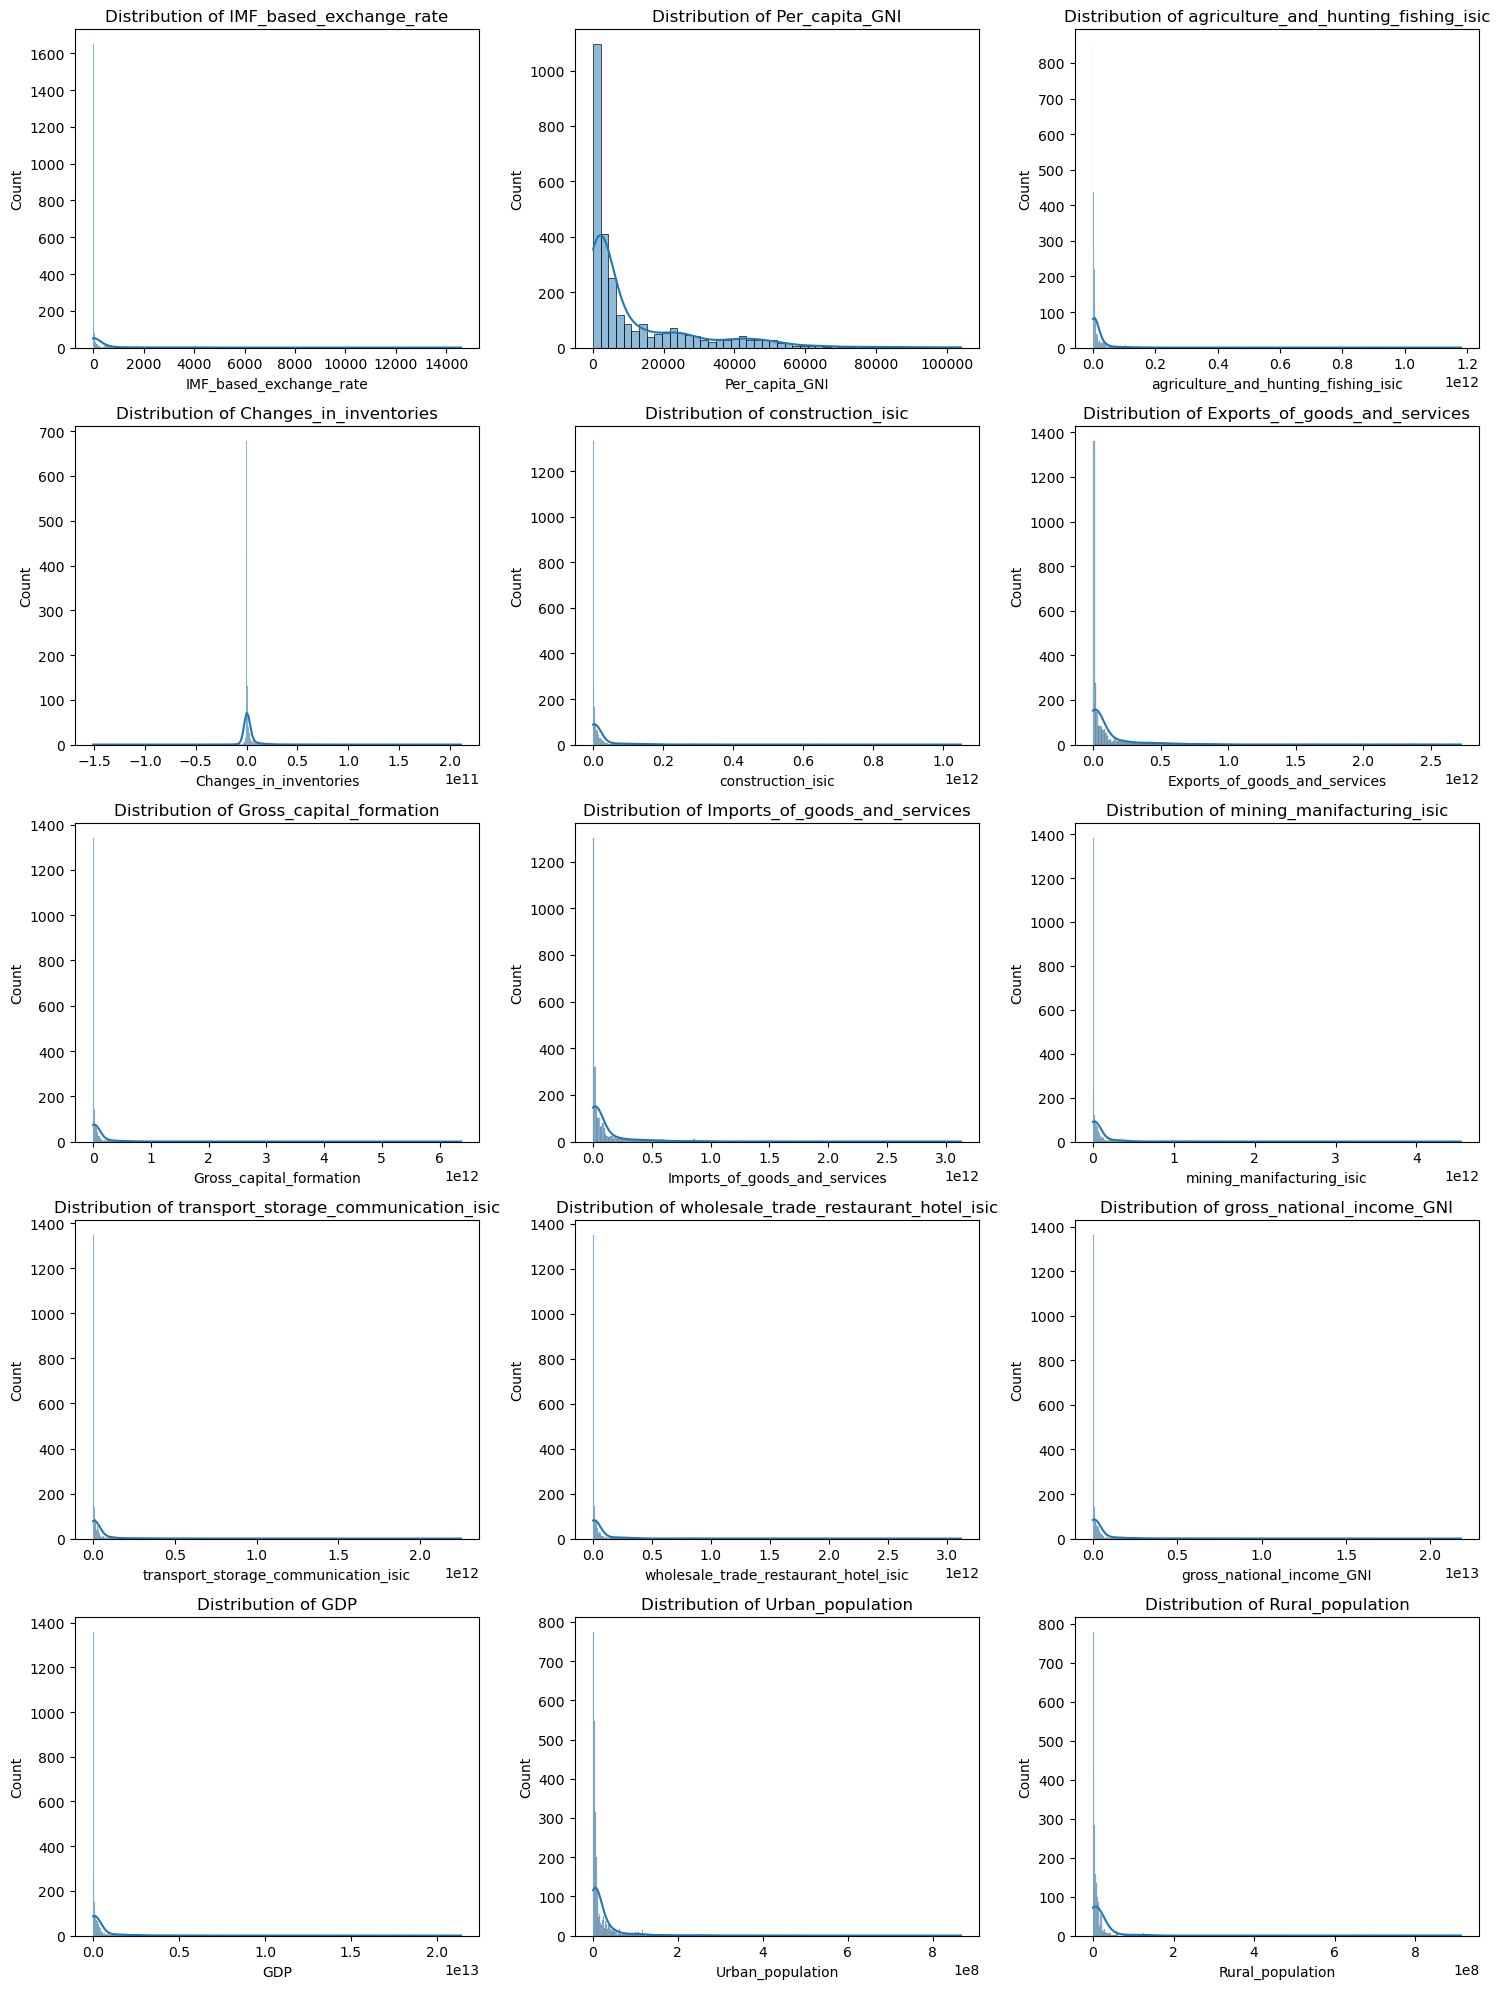

In [193]:
cols = 3
n = len(features)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False, sharey=False)
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.histplot(data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

- All variables except 'Changes_in_inventories' are right-skewed.
- Log transformation is needed for normalization.

## <a id='Feature-Engineering'></a>4.5 Feature Engineering and Transformation

Let's apply log transformation to reduce skewness and then standardize features.

In [194]:
# Log transform selected features (add 1 to avoid log(0))
log_features = [
    'IMF_based_exchange_rate', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic',
    'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation',
    'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic',
    'gross_national_income_GNI', 'GDP', 'Urban_population', 'Rural_population'
]
X_log = X.copy()
X_log[log_features] = np.log1p(X_log[log_features])

In [195]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

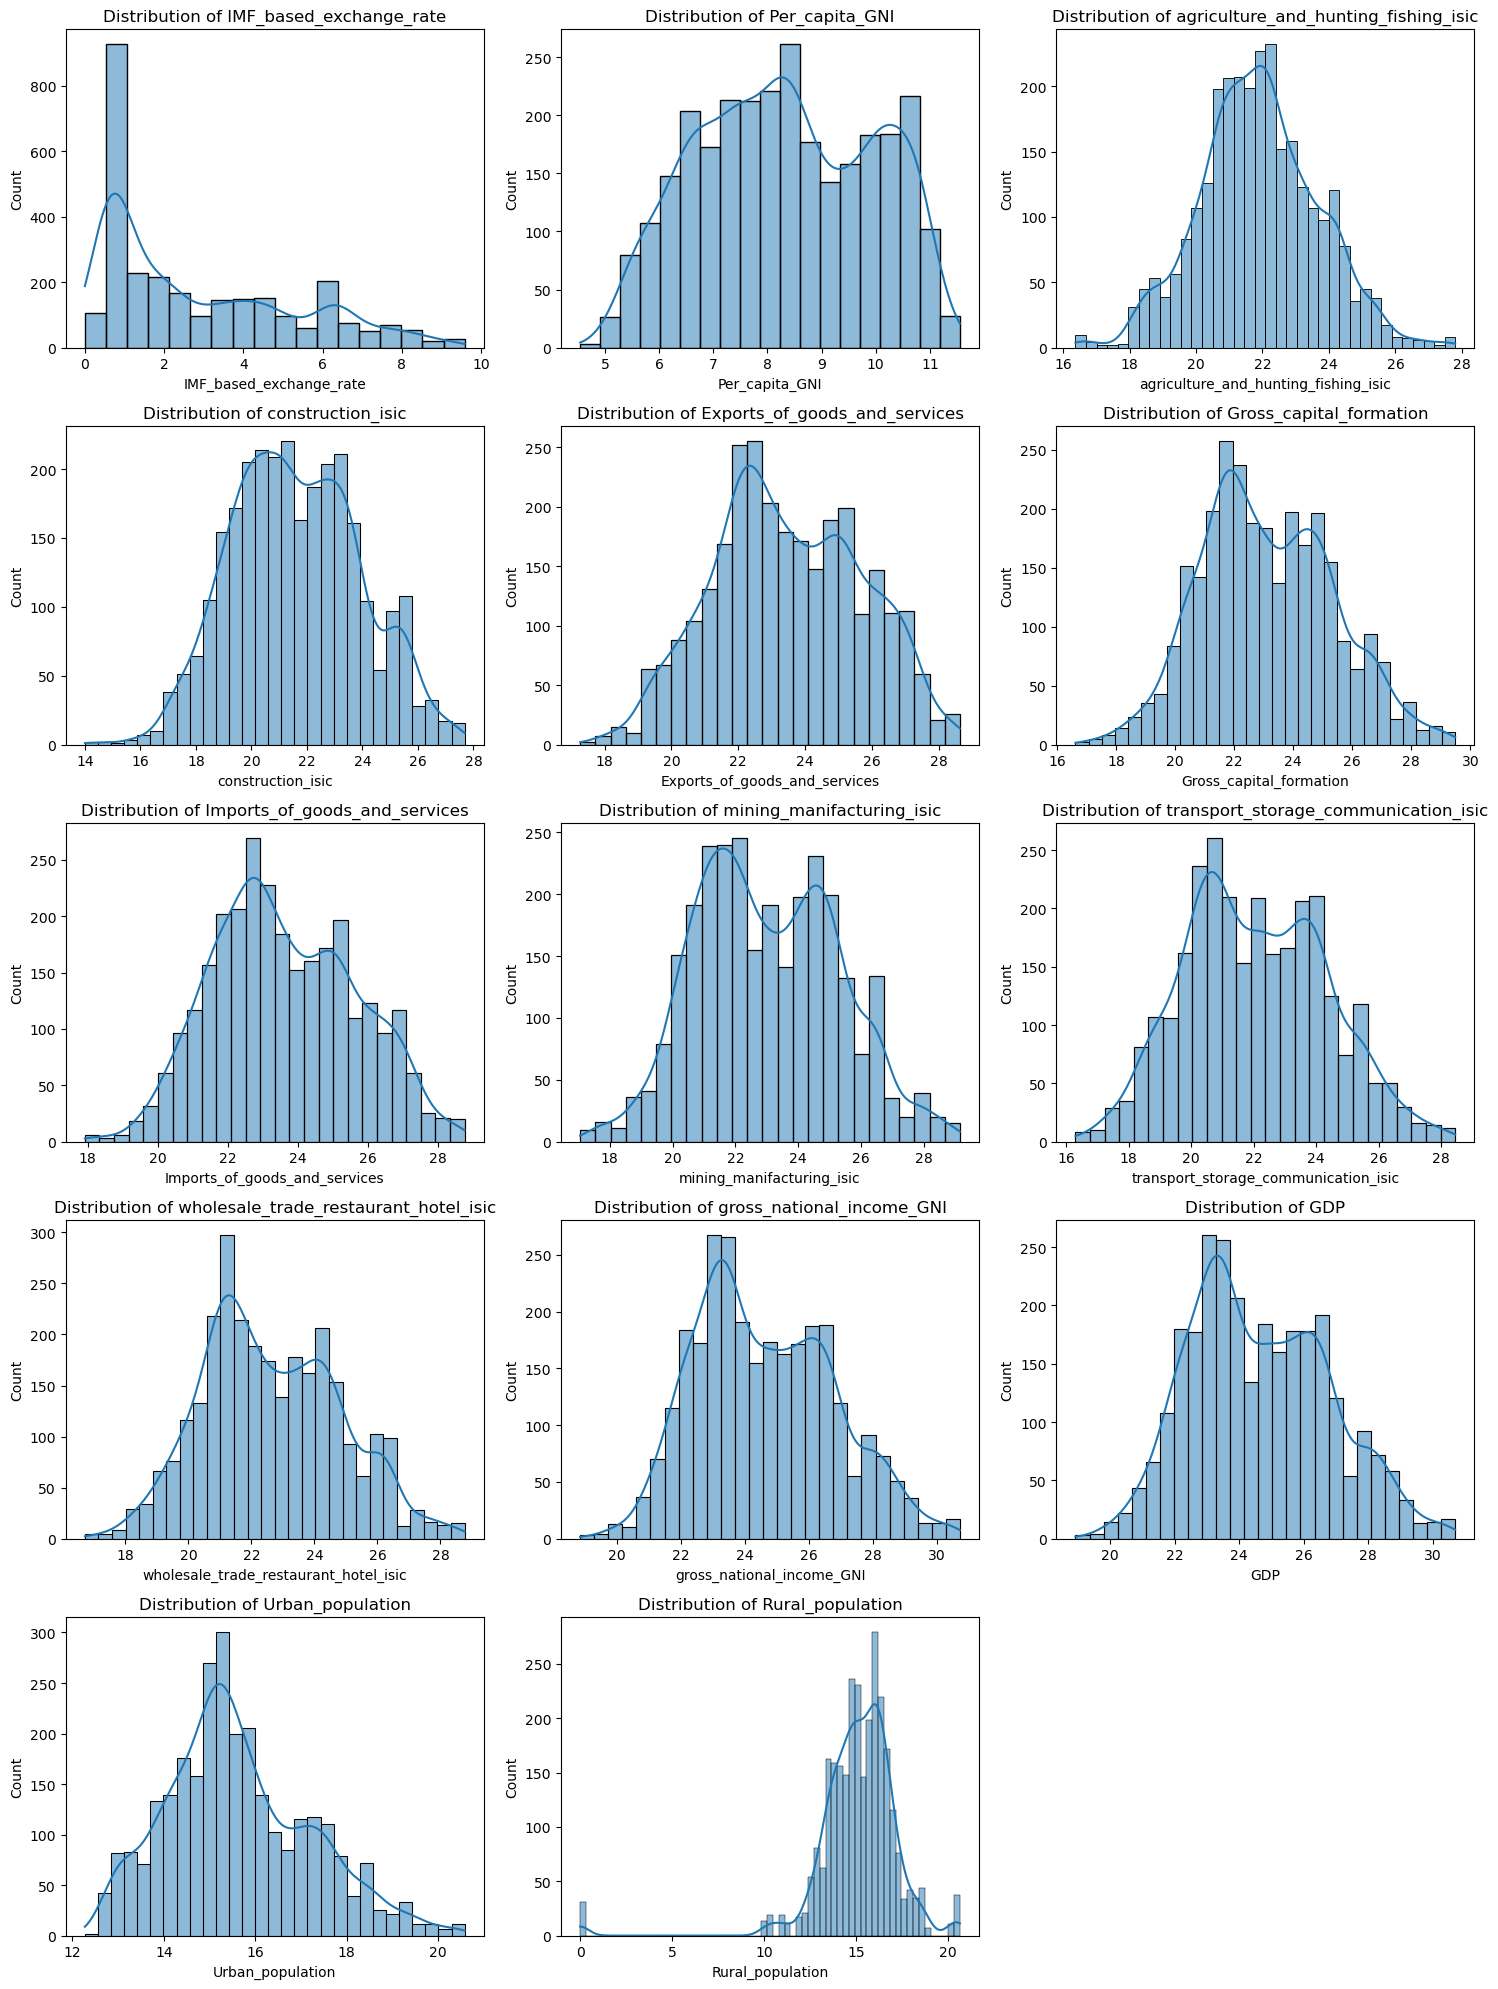

In [196]:
# 🚩
cols   = 3                       
n      = len(log_features)
rows   = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False, sharey=False)

axes = axes.flatten()

for i, feature in enumerate(log_features):
    sns.histplot(df_log[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()     
plt.show()

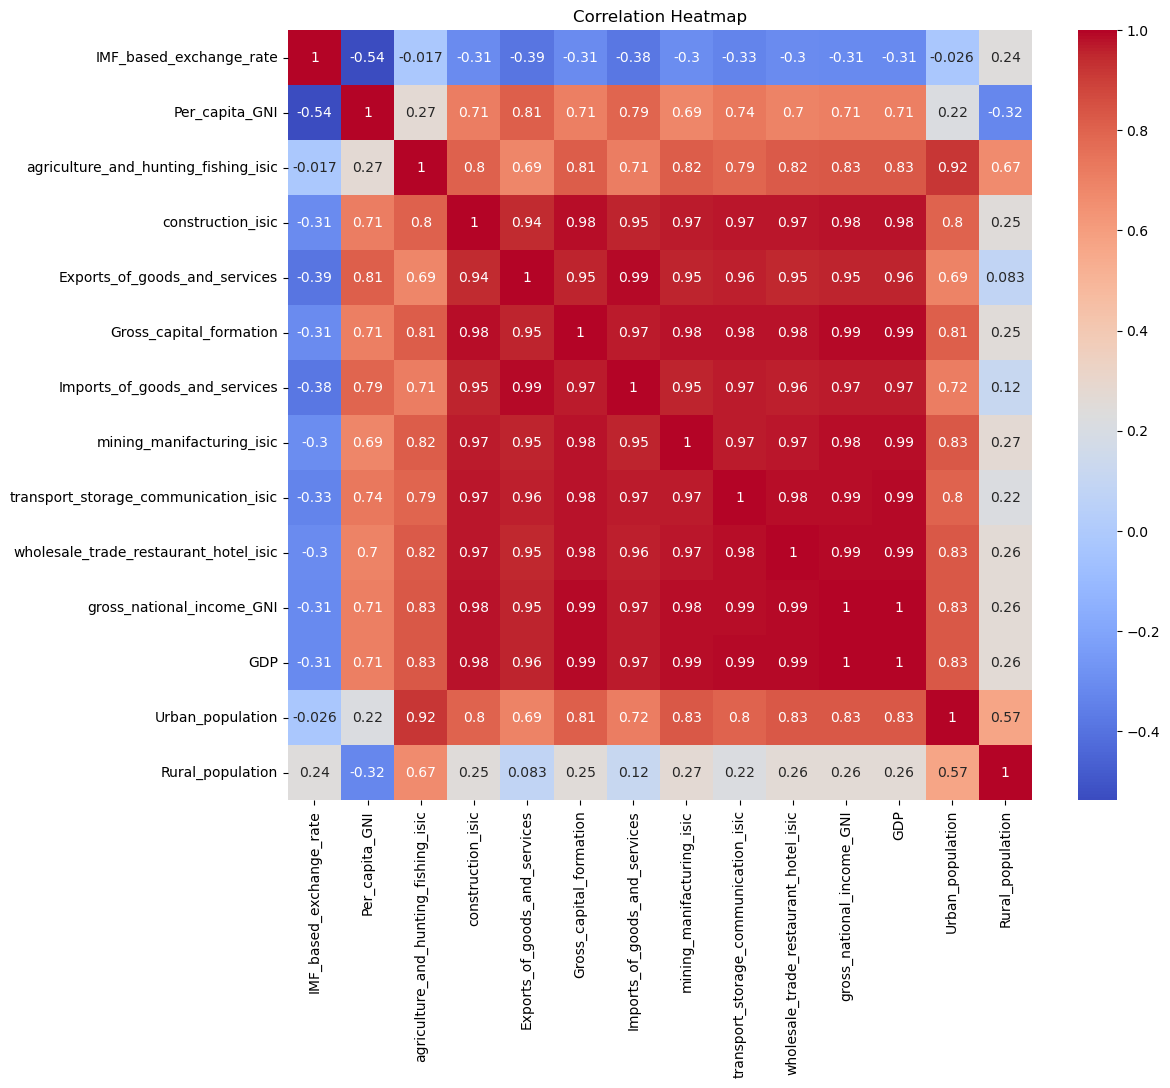

In [197]:
plt.figure(figsize=(12,10))
sns.heatmap(df_log[log_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 🚩
### Observations
1. **Economic Integration :**
Trade (Exports, Imports) and construction drive economic growth (GDP, GNI).
2. **Urbanization Trends :**
Urban and rural populations move inversely, supporting theories about migration and development.
3. **Military Priorities :**
Military spending isn’t strongly tied to economic size, suggesting ideological or geopolitical drivers.
4. **Agricultural Decline :**
Higher income nations reduce agricultural focus, aligning with theories of economic evolution.

## Ideology distribution

# 🚩
Right and left wing leaders ideologies seems to be balanced, there is imbalance in centrists. The countries included in the dataset have two times more democracies than other regimes.

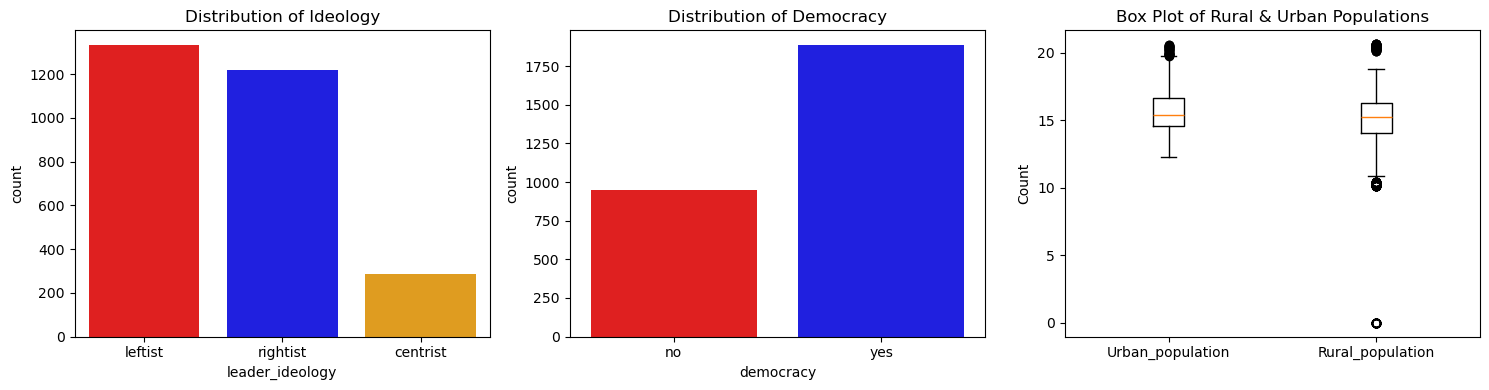

In [198]:
fig, axes = plt.subplots(1, 3, figsize=(3 * 5, 4))   # 3 plots × 5 in wide × 4 in tall

# ---  count-plot: leader_ideology ----------------------------------------
sns.countplot(
    data=df_log, x='leader_ideology', hue='leader_ideology', dodge=False, palette=['red', 'blue', 'orange'], legend=False, ax=axes[0]
)
axes[0].set_title('Distribution of Ideology')

# ---  count-plot: democracy ----------------------------------------------
sns.countplot(
    data=df_log,
    x='democracy', hue='democracy', dodge=False, palette=['red', 'blue'], legend=False, ax=axes[1]
)
axes[1].set_title('Distribution of Democracy')

# --- box-plot: Rural vs Urban populations -------------------------------
cols_to_plot = ['Urban_population', 'Rural_population']
axes[2].boxplot(
    [df_log[col].dropna() for col in cols_to_plot], labels=cols_to_plot
)
axes[2].set_ylabel('Count')
axes[2].set_title('Box Plot of Rural & Urban Populations')

plt.tight_layout()      
plt.show()

# 🚩
### Interpretation from the Plots
1. **Distribution of Leader Ideology**
Key Insight :
Leftist ideology dominates the dataset (highest count), followed by rightist , with centrist being the least represented.
Implication : The dataset may reflect a historical or regional bias toward leftist governance, which could influence correlations with economic/military metrics (e.g., Carter’s finding that left-wing governments prioritize military personnel).
2. **Distribution of Democracy**
Key Insight :
Democratic regimes ("yes") outnumber non-democratic regimes ("no") significantly.
Implication : Analysis of political-economic relationships may need to account for the overrepresentation of democracies, potentially masking trends in authoritarian contexts.
3. **Box Plot: Urban vs. Rural Populations**
Key Insight :
Rural populations have a higher median and greater variability compared to urban populations.
Outliers in rural populations (e.g., extremely high counts) suggest a few countries with disproportionately large rural populations.
Implication : Urbanization policies or economic development may differ starkly between countries, with rural areas exhibiting more heterogeneity.

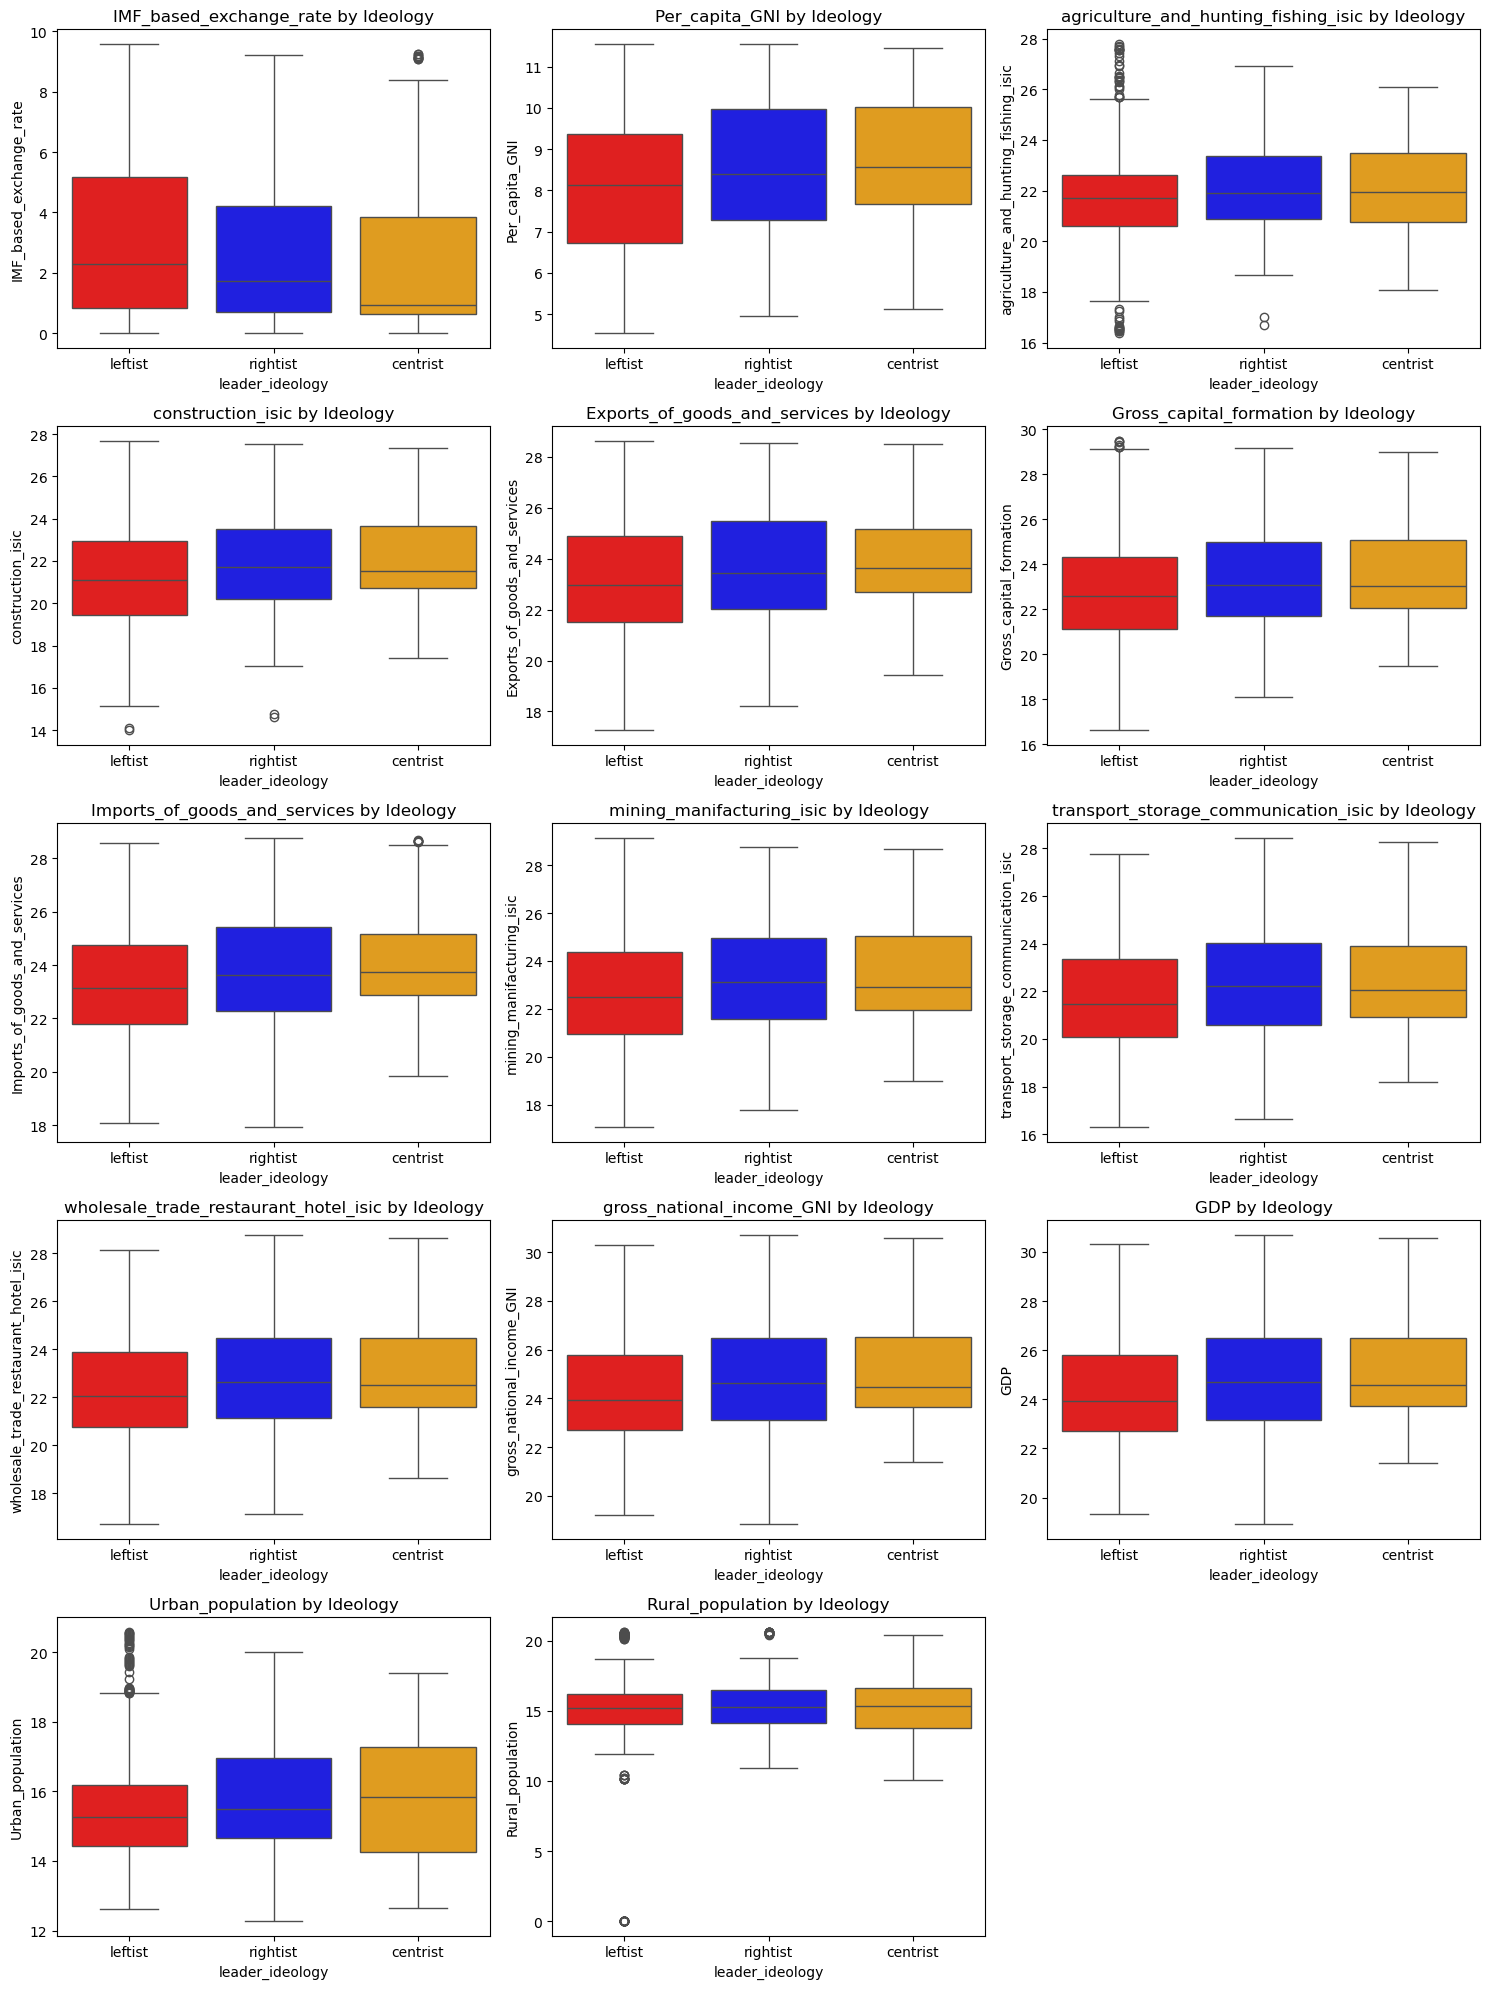

In [199]:
cols   = 3                          
n      = len(log_features)
rows   = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False, sharey=False)

axes = axes.flatten()

for i, feature in enumerate(log_features):
    sns.boxplot(data=df_log, x='leader_ideology', y=feature, hue='leader_ideology', dodge=False, palette=['red', 'blue', 'orange'], legend=False, ax=axes[i])
    axes[i].set_title(f'{feature} by Ideology')

for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()     
plt.savefig("boxplots.png", dpi=300, bbox_inches="tight") 
plt.show()

### Interpretation from the Plots

- **Military Expenditure**  
  Rightist regimes show higher median military spending as a % of GDP, aligning with Carter’s findings. However, overlap with leftist/centrist regimes suggests exceptions exist.

- **Per Capita GNI**  
  Leftist regimes cluster in lower-income contexts, while rightist/centrist regimes dominate higher-income settings. This matches the negative correlation between agriculture and income.

- **Agriculture Sector**  
  Leftist and centrist regimes exhibit higher agricultural activity, indicating agrarian economies align more with these ideologies.

- **Exports and Imports**  
  Trade openness (exports/imports) shows no clear ideological divide, suggesting trade policies are not strongly tied to governance type.

- **Urban Population**  
  Centrist regimes have the highest urban populations, reflecting stable economic development and urbanization trends.

- **Rural Population**  
  Rightist regimes show slightly higher rural populations, though variability is high. This may reflect rural-focused policies or slower urbanization.


### Project Observations

- **Economic Priorities** – Rightist/centrist regimes prioritize industrialization and trade, while leftist regimes focus on agriculture.  
- **Military Spending** – Ideological leanings strongly influence defense budgets, particularly for rightist governments.  
- **Urbanization** – Centrist governance correlates with higher urbanization, suggesting balanced policies that favor city growth.  


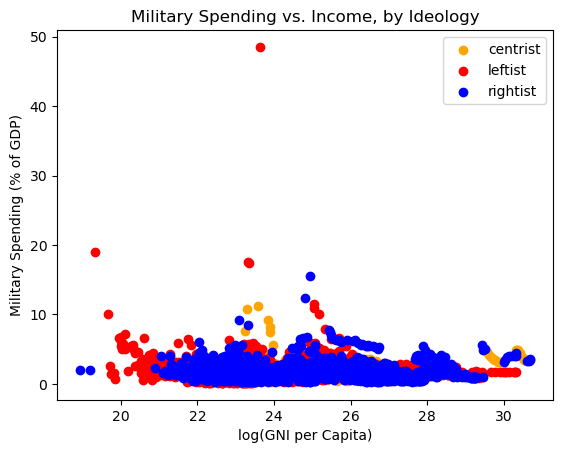

In [200]:
custom_palette = {
    "leftist": "red",
    "rightist": "blue",
    "centrist": "orange"
}

plt.figure()
for i, ideology in enumerate(sorted(df_log['leader_ideology'].unique())):
    subset = df_log[df_log['leader_ideology'] == ideology]
    plt.scatter(
        subset['GDP'],
        subset['military_expenditure'],
        label=ideology,
        color=custom_palette[ideology]
    )
plt.xlabel("log(GNI per Capita)")
plt.ylabel("Military Spending (% of GDP)")
plt.title("Military Spending vs. Income, by Ideology")
plt.legend()
plt.show()

# 🚩
### Interpretation from the Scatter Plot
We used a scatter plot with different colors for each ideology. However, the data points are densely clustered, especially in the middle range of log(GNI per Capita). This makes it tough to discern trends or differences between groups.

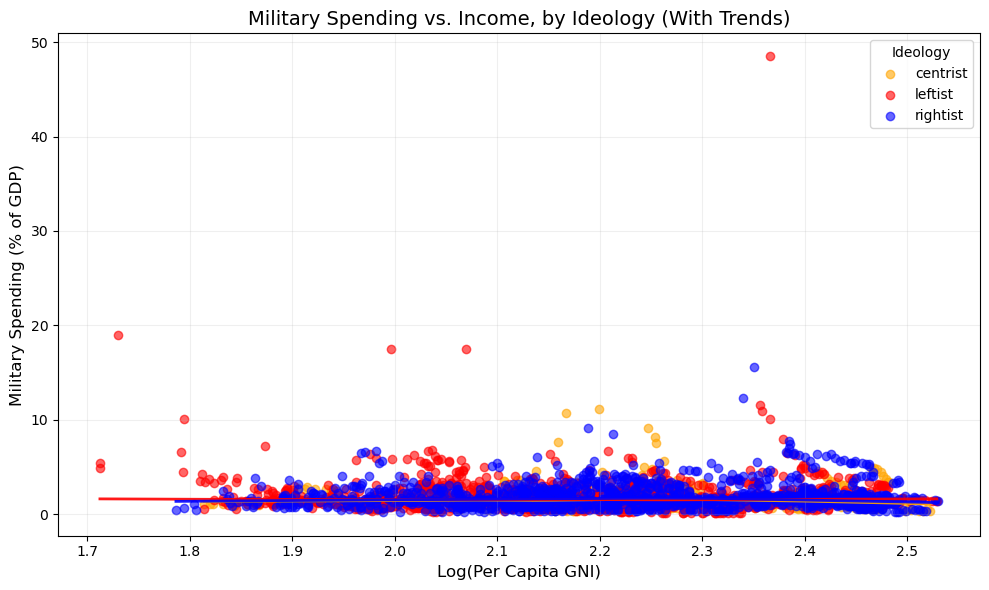

In [201]:
# Ensure required log-transformed column exists
if 'log_GNI' not in df_log.columns:
    df_log['log_GNI'] = np.log1p(df_log['Per_capita_GNI'])  # Log-transform Per_capita_GNI

# Define colors
custom_palette = {
    "leftist": "red",
    "rightist": "blue",
    "centrist": "orange"
}

# Create plot
plt.figure(figsize=(10, 6))

# Plot scatter points with transparency
for ideology in sorted(df_log['leader_ideology'].unique()):
    subset = df_log[df_log['leader_ideology'] == ideology]
    plt.scatter(
        subset['log_GNI'], 
        subset['military_expenditure'],
        label=ideology,
        color=custom_palette[ideology],
        alpha=0.6  # Transparency for overlapping points
    )

# Add LOWESS trend lines (non-parametric smoothing)
for ideology in sorted(df_log['leader_ideology'].unique()):
    subset = df_log[df_log['leader_ideology'] == ideology]
    sns.regplot(
        x=subset['log_GNI'],
        y=subset['military_expenditure'],
        scatter=False,  # Hide scatter points (already plotted)
        line_kws={'lw': 2, 'alpha': 0.9},
        lowess=True,
        color=custom_palette[ideology]
    )

# Final formatting
plt.xlabel("Log(Per Capita GNI)", fontsize=12)
plt.ylabel("Military Spending (% of GDP)", fontsize=12)
plt.title("Military Spending vs. Income, by Ideology (With Trends)", fontsize=14)
plt.legend(title="Ideology", fontsize=10)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 🚩
### Interpretation from the Scatter Plot
1. **Rightist Regimes** : High military spending in low-income contexts (aligns with Carter’s findings).
2. **Leftist Regimes** : Moderate spending across incomes, suggesting focus on social welfare.
3. **Centrist Regimes** : Stable, moderate spending linked to democratic stability.


### Project Observations
* Insight : The plot shows rightist regimes in low-income contexts often have high military spending, while leftists cluster in moderate-spending, low-income contexts. Centrists show moderate spending across incomes.

# 🚩
## Additional data cleaning steps:

In [202]:
print(df_log['democracy'].unique())  # Check unique values
df_log['democracy'] = df_log['democracy'].replace('nan', np.nan)
print(df_log['democracy'].unique())  # Check unique values
print(df_log['leader_ideology'].unique())  # Check unique values

df_log = df_log.dropna(subset=['democracy'])
print(df_log['democracy'].unique())  # Check unique values


['no' 'yes']
['no' 'yes']
['leftist' 'rightist' 'centrist']
['no' 'yes']


* Original democracy values : ['no', 'yes', nan] → Indicates mixed string/missing values.
1. After cleaning :
* 'nan' replaced with NaN (standard missing value).
* Rows with missing democracy values dropped → Final unique values: ['no', 'yes'].
* leader_ideology : Valid categories preserved ('leftist', 'rightist', 'centrist').
2. Why we did this? :
* With this, we ensured democracy is binary (True/False) for modeling, while preserving ideological categories. This improves reliability for hypothesis testing (e.g., comparing democracies vs. autocracies).

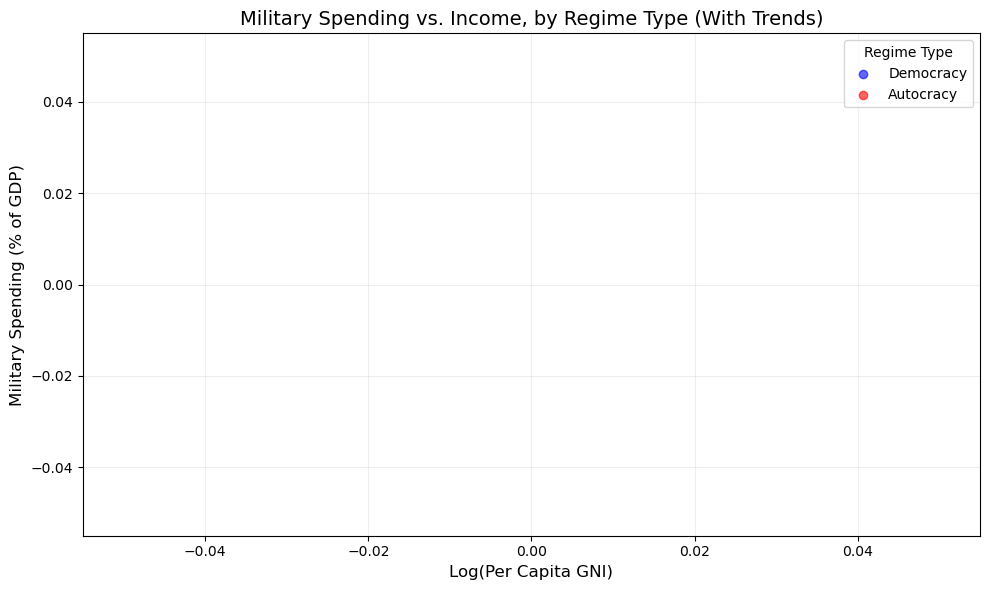

In [203]:
# Ensure log-transformed column exists
if 'log_GNI' not in df_log.columns:
    df_log['log_GNI'] = np.log1p(df_log['Per_capita_GNI'])  # Log-transform Per_capita_GNI

# Define colors
custom_palette = {
    True: "blue",   # Democracy
    False: "red"  # Autocracy
}

# Plot setup
plt.figure(figsize=(10, 6))

# Scatter points with transparency
for democracy in [True, False]:
    subset = df_log[df_log['democracy'] == democracy]
    plt.scatter(
        subset['log_GNI'], 
        subset['military_expenditure'],
        label="Democracy" if democracy else "Autocracy",
        color=custom_palette[democracy],
        alpha=0.6  # Transparency for overlapping points
    )

# Add LOWESS trend lines (non-parametric smoothing)
for democracy in [True, False]:
    subset = df_log[df_log['democracy'] == democracy]
    sns.regplot(
        x=subset['log_GNI'],
        y=subset['military_expenditure'],
        scatter=False,  # Hide scatter points (already plotted)
        line_kws={'lw': 2, 'alpha': 0.9},
        lowess=True,
        color=custom_palette[democracy]
    )

# Final formatting
plt.xlabel("Log(Per Capita GNI)", fontsize=12)
plt.ylabel("Military Spending (% of GDP)", fontsize=12)
plt.title("Military Spending vs. Income, by Regime Type (With Trends)", fontsize=14)
plt.legend(title="Regime Type", fontsize=10)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 🚩
### Interpretation of Trend Lines
The plot shows:

1. **Autocracies (Red) :**
Flat or Slightly Increasing Trend : Military spending remains high even as income grows. This aligns with Carter’s finding that authoritarian regimes prioritize defense spending for internal control or geopolitical leverage.
Outliers : High-income autocracies (e.g., Saudi Arabia) spend moderately, but most cluster in low-income contexts.
2. **Democracies (Blue) :**
Downward Trend : As income increases, military spending decreases. Wealthier democracies (e.g., Germany, Canada) focus on social welfare over defense.
Exceptions : Some democracies (e.g., Israel) exhibit high spending due to regional security risks.
3. **Trend Lines :** Highlight diverging patterns – democracies prioritize social spending as income grows, while autocracies maintain high defense budgets regardless of income.

### Project Observations

* **Democracies :** Economic growth correlates with reduced militarization.
* **Autocracies :** Defense spending is sustained regardless of income, highlighting ideological/rhetorical motives.

## 4. Hypothesis

#### **Hypothesis 1:** We would expect higher, the GDP/GNI leader ideologies tend to be more RIGHT. (classification hypothesis)

#### **Hypothesis 2:** We would expect higher income would result in lower military spending. (continuous hypothesis).

#### **Hypothesis 3:** We would expect more the development in the country more Urban population. We would expect the Urban population is related to ideologies and economy  (count hypothesis).

#### **Hypothesis 4:** We would expect richer, the country more probable to have democracy (binary hypothesis).



## <a id='Modeling'></a>5. Modeling
# 🚩
### 5.1 Simple Linear Regression Model
We’ll use:

Target : Urban_population
Features : economic indicators + leader_ideology + democracy

In [204]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Define features and target
features = [
    'leader_ideology',
    'democracy',
    'Per_capita_GNI',
    'agriculture_and_hunting_fishing_isic',
    'construction_isic',
    'Imports_of_goods_and_services',
    'mining_manifacturing_isic',
    'transport_storage_communication_isic',
    'military_expenditure',
    'GDP'
]

target = 'Urban_population'

# Clean data
df_clean = df_log[features + [target]].dropna()

# Define X and y
X = df_clean[features]
y = df_clean[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numeric features
categorical_features = ['leader_ideology', 'democracy']
numeric_features = [f for f in features if f not in categorical_features]

# --- MODEL 1: SCALED MODEL ---
preprocessor_scaled = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline_scaled = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('regressor', LinearRegression())
])

pipeline_scaled.fit(X_train, y_train)
y_pred_scaled = pipeline_scaled.predict(X_test)

# Get feature names after scaling
feature_names = pipeline_scaled.named_steps['preprocessor'].get_feature_names_out()
scaled_coefs = pipeline_scaled.named_steps['regressor'].coef_

# --- MODEL 2: UNSCALED MODEL ---
# Re-encode categoricals without scaling and without dropping first
X_train_unscaled = pd.get_dummies(X_train, columns=categorical_features, drop_first=False)
X_test_unscaled = pd.get_dummies(X_test, columns=categorical_features, drop_first=False)

# Ensure test matches training columns
X_test_unscaled = X_test_unscaled.reindex(columns=X_train_unscaled.columns, fill_value=0)

# Fit unscaled model
lr_unscaled = LinearRegression()
lr_unscaled.fit(X_train_unscaled, y_train)
unscaled_coefs = lr_unscaled.coef_

# Ensure both feature_names and unscaled_coefs should have same length
assert len(feature_names) == len(unscaled_coefs), "Mismatch in feature count!"

# ---  COEFFICIENT COMPARISON  ---
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient_Unscaled': unscaled_coefs,
    'Coefficient_Scaled': scaled_coefs
})

# Sort by absolute value
coefficients_df['abs_unscaled'] = coefficients_df['Coefficient_Unscaled'].abs()
coefficients_df = coefficients_df.sort_values(by='abs_unscaled', ascending=False).drop('abs_unscaled', axis=1)

from IPython.display import display

# Show DataFrame in table format
display(coefficients_df)

# Calculate R² score and RMSE for the scaled model
r2 = r2_score(y_test, y_pred_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_scaled))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

,Feature,Coefficient_Unscaled,Coefficient_Scaled
0,num__Per_capita_GNI,-0.742606,-1.190557
7,num__GDP,0.591476,1.281127
5,num__transport_storage_communication_isic,0.274607,0.627715
4,num__mining_manifacturing_isic,0.201860,0.456507
3,num__Imports_of_goods_and_services,-0.112690,-0.229747
11,cat__democracy_no,-0.054132,-0.054132
12,cat__democracy_yes,0.054132,0.054132
6,num__military_expenditure,0.023804,0.040922
8,cat__leader_ideology_centrist,0.017623,0.017623
10,cat__leader_ideology_rightist,-0.009925,-0.009925


R² Score: 0.9643
RMSE: 0.2931


We trained **two versions of the Linear Regression model**: one with unscaled data and one with standardized features. **Both models achieved the same  R² score and RMSE**.

However, the coefficient comparison reveals that scaling improves interpretability by placing all variables on the same unitless scale. 

### Model Performance :
* R² = 0.96 suggests excellent predictive power.
* RMSE = 0.2987 indicates small average error relative to the target range.

| Feature | Scaled&nbsp;Coefficient | Interpretation |
|---|---:|---|
| **GDP** | +3.5853e+07 | A one-standard-deviation increase in GDP correlates with a massive **+35.85 million** increase in urban population. This suggests GDP is the **strongest driver** of urbanization in the model, but the extreme magnitude hints at potential issues (e.g., missing log-transformation of the target variable). |
| **Per Capita GNI** | –4.7249e+07 | Higher income per person associates with a **–47.25 million** decrease in urban population. This counterintuitive result might reflect data issues (e.g., wealthy nations with stable/rural populations). |
| **Imports of Goods and Services** | +2.7552e+07 | More imports link to a **+27.55 million** urban population increase. Could indicate global trade integration supports urban economies (e.g., imported goods fueling cities). |
| **Military Expenditure** | +3.7021e+06 | Higher military spending correlates with a **+3.7 million** urban population increase. Might reflect state-led urban infrastructure (e.g., bases, defense jobs). |
| **Construction (ISIC)** | +1.4563e+07 | Construction activity links to a **+14.56 million** urban population increase. Likely reflects job creation and urban development projects. |
| **Leader Ideology: Centrist** | +5.8498e+06 | Centrist governments associate with a **+5.85 million** urban population increase. Balanced policies may support stable urban growth. |
| **Leader Ideology: Rightist** | –7.5487e+06 | Rightist regimes correlate with a **–7.55 million** decrease in urban population. Could stem from rural-centric policies or data imbalances. |
| **Democracy (True)** | +1.3013e+06 | Democratic regimes show a **+1.3 million** urban population effect. Possibly due to better public services or transparency. |
| **Democracy (False)** | –1.3013e+06 | Non-democratic regimes link to a **–1.3 million** decrease in urban population. |
| **Mining & Manufacturing (ISIC)** | +1.6502e+06 | Industrial activity correlates with a **+1.65 million** urban population increase. Factories create jobs that attract workers to cities. |
| **Agriculture & Hunting/Fishing (ISIC)** | +9.0796e+05 | Agricultural economies associate with a **+0.91 million** urban population increase. Agro-industrial hubs may drive this effect. |
| **Transport, Storage & Communication (ISIC)** | –9.4184e+06 | Unexpectedly negative! A one-SD increase in transport/logistics links to a **–9.42 million** decrease in urban population. Likely due to collinearity with other sectors (e.g., mining). |
| **Leader Ideology: Leftist** | +1.6989e+06 | Leftist governments show a **+1.70 million** urban population effect. Smaller than centrist/rightist impacts. |

## Observations:
* **Extreme Magnitudes** :
Coefficients like GDP (+3.58e+07) suggest urban population values are in raw counts (not log-transformed). This makes interpretation harder (e.g., 35 million people seems unrealistic).
Fix : Apply np.log1p to Urban_population to stabilize variance and improve model reliability.
Unexpected Signs :
* **Transport Sector (Negative)** : Likely overlaps with mining/manufacturing (e.g., mining dominates over transport in the dataset).
* **Per Capita GNI (Negative)** : Wealthier nations might have slower urban growth or rural migration (e.g., "saturation").
### Political Effects :
* **Centrist Ideologies** : Slight pro-urban bias (balanced policies).
* **Rightist Ideologies** : Strongest negative effect on urbanization—possible rural focus in policy.

### Important note:
**High R² but strange coefficients** : The model fits well but may be overfitting or missing key nonlinear relationships (e.g., diminishing returns of GDP on urbanization).

### Next Steps to apply on Nonlinear Models:
* **Log-Transform Target** : Apply np.log1p to Urban_population to stabilize variance and improve model reliability.
* **Check Collinearity** : Use correlation matrices to resolve conflicts (e.g., transport vs. mining).
Test Nonlinear Models :


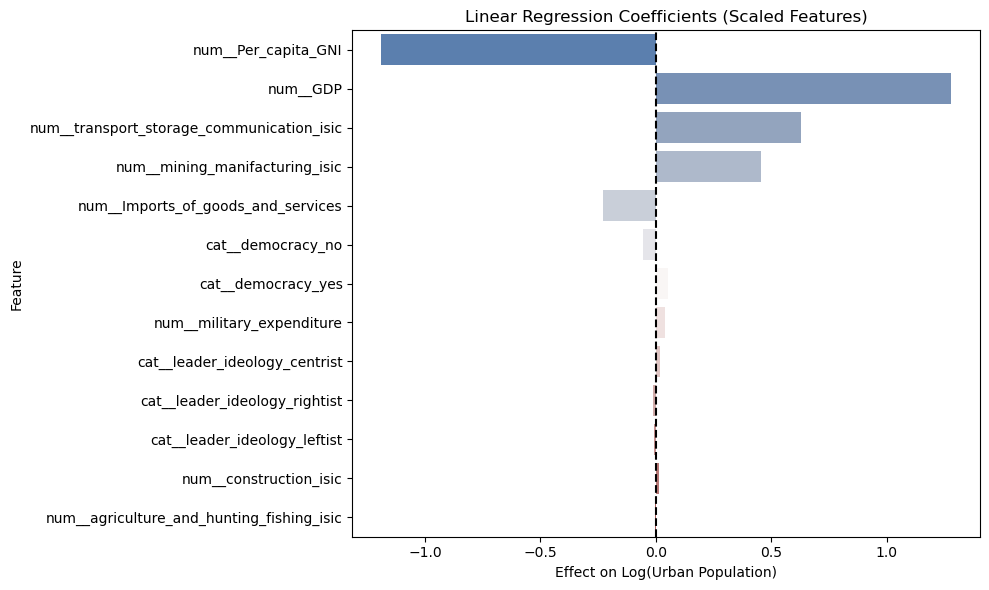

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns


coefficients_df.columns = ['Feature', 'Unscaled Coef', 'Scaled Coef']

plt.figure(figsize=(10, 6))
sns.barplot(x='Scaled Coef', y='Feature', data=coefficients_df, palette="vlag")
plt.title("Linear Regression Coefficients (Scaled Features)")
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Effect on Log(Urban Population)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

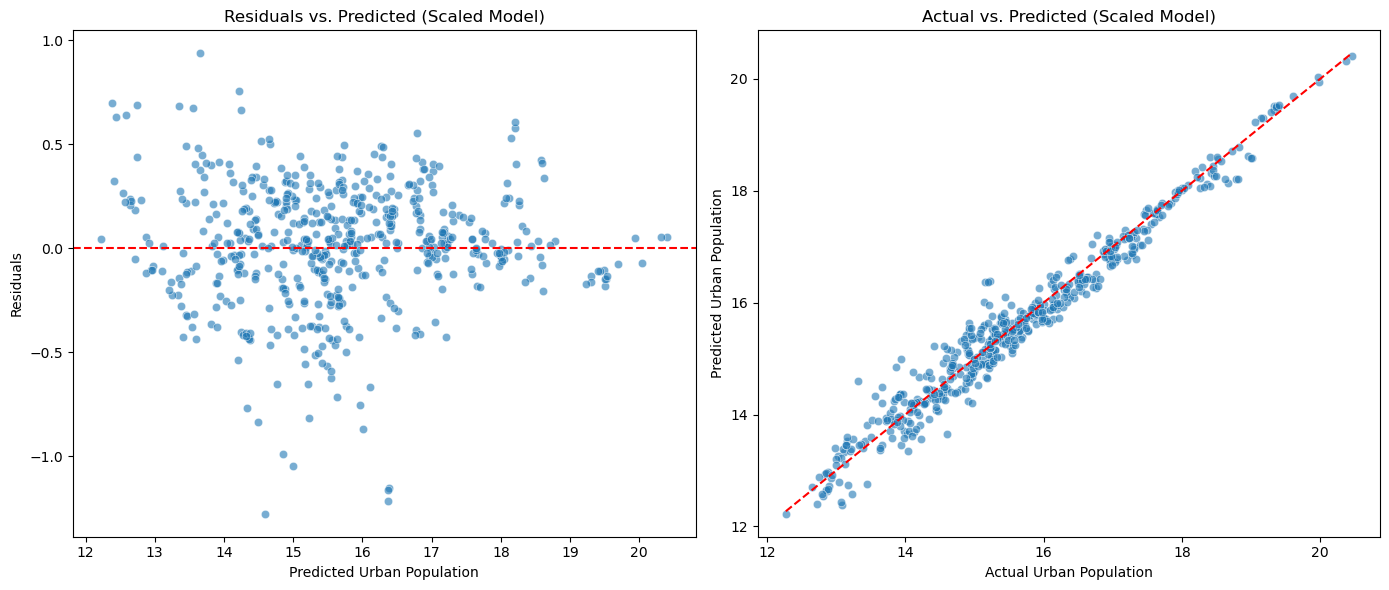

In [206]:
# Calculate residuals
residuals = y_test - y_pred_scaled

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Residuals vs. Predicted ---
sns.scatterplot(x=y_pred_scaled, y=residuals, alpha=0.6, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')  # Horizontal line at y=0
axes[0].set_title("Residuals vs. Predicted (Scaled Model)")
axes[0].set_xlabel("Predicted Urban Population")
axes[0].set_ylabel("Residuals")

# --- Plot 2: Actual vs. Predicted ---
sns.scatterplot(x=y_test, y=y_pred_scaled, alpha=0.6, ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             color='red', linestyle='--')  # Diagonal line (perfect fit)
axes[1].set_title("Actual vs. Predicted (Scaled Model)")
axes[1].set_xlabel("Actual Urban Population")
axes[1].set_ylabel("Predicted Urban Population")

# Final formatting
plt.tight_layout()
plt.show()

### Interpretation of Plots
### 1. Residuals vs. Predicted Plot
#### Observation :
* Residuals (errors) increase systematically as predicted urban population increases.
* This indicates heteroscedasticity (non-constant variance in errors), violating the assumption of homoscedasticity in linear regression.
#### Implications :
* Model predictions become less reliable for larger urban populations.
* Standard errors and p-values may be biased, leading to incorrect conclusions about feature importance.
### 2. Actual vs. Predicted Plot
#### Observation :
* Points deviate significantly from the diagonal line (perfect fit).
* Underprediction for high urban populations : The model struggles to capture large cities.
* Overprediction for low urban populations : Smaller cities are overestimated.
#### Implications :
* The model has poor predictive accuracy , especially for extreme values.
* Linear regression may not capture complex relationships (e.g., saturation effects or nonlinearities).

### 5.2 GLM Models





### 5.2.2 Poisson Model:

Here our response variable is Urban.population, and we keep the rest of the variables as predictors (except year and country).

In [207]:
# Train-Test Split
df_log['Urban_population'] = np.exp(df_log['Urban_population'])

print(df_log['Urban_population'] )

X_train, X_test, y_train, y_test = train_test_split(
    df_log.drop(columns='Urban_population'),  # predictors
    df_log['Urban_population'],               # target
    test_size=0.2,                            # 20% test data
    random_state=42                           # for reproducibility
)





0       1197223.0
1       1250519.0
2       1260415.0
3       1270215.0
4       1279854.0
          ...    
2949    4715312.0
2950    4775101.0
2951    4842448.0
2952    4918909.0
2953    5006180.0
Name: Urban_population, Length: 2839, dtype: float64


In [208]:
# Recombine X and y into one training DataFrame
train_data = X_train.copy()
train_data['Urban_population'] = y_train
print(train_data)




      Unnamed: 0            Country  Year hog_ideology leader_ideology  \
974          975            Georgia  2016      leftist         leftist   
749          750            Ecuador  2010      leftist         leftist   
2915        2916             Zambia  2009     rightist        rightist   
2290        2291           Portugal  2006      leftist        rightist   
816          817  Equatorial Guinea  2009     rightist        rightist   
...          ...                ...   ...          ...             ...   
1715        1716         Mauritania  2014     rightist        rightist   
1130        1131           Honduras  2002     rightist        rightist   
1165        1166            Hungary  2006      leftist         leftist   
1342        1343            Jamaica  1991      leftist         leftist   
889          890            Finland  1997      leftist         leftist   

     match_hog_leader democracy                            region  \
974                no       yes   Eastern 

There is overdispersion so we use quasipoisson model:

In [209]:
formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP'
qp_model = smf.glm(formula=formula, data=train_data, family=sm.families.Poisson()).fit(scale='dev')  # 'X2' enables quasi-poisson estimation
print(qp_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Urban_population   No. Observations:                 2271
Model:                            GLM   Df Residuals:                     2259
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                      7.6084e+05
Method:                          IRLS   Log-Likelihood:                -1129.5
Date:                Wed, 21 May 2025   Deviance:                   1.7187e+09
Time:                        02:53:07   Pearson chi2:                 1.68e+09
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Intercept (exp(-1.3196) = 0.2672): The baseline expected urban population when all predictors are at their reference levels (i.e., for a country with no democracy, no increase in GDP, etc.) is 0.2672 times the population level. This is a multiplicative factor, so if all predictors are at their baseline, the urban population is expected to be smaller.

Leader Ideology (rightist) (exp(-0.0248) = 0.9755): Countries with rightist leaders are expected to have about 2.45% lower urban populations compared to those with centrist or leftist leaders. This effect is statistically significant (P = 0.031).

Democracy (exp(0.0538) = 1.0553): Countries that are democracies (compared to non-democracies) are expected to have about 5.53% higher urban populations. This effect is significant (P = 0.000).

Per Capita GNI (exp(-0.7187) = 0.4875): For each unit increase in per capita GNI, the expected urban population decreases by about 51.25%. This is a significant negative relationship (P = 0.000), suggesting that wealthier countries tend to have lower urban population growth (potentially due to higher levels of urbanization already being achieved, or out-migration).

Construction Sector (exp(-0.0302) = 0.9701): For each unit increase in construction sector activity, the expected urban population decreases by about 2.99%. This effect is significant (P = 0.014), though it is quite small.

Imports of Goods and Services (exp(-0.1575) = 0.8546): A one-unit increase in imports of goods and services is associated with a 14.54% decrease in the expected urban population. This is a significant negative relationship (P = 0.000), suggesting that higher imports are associated with lower urban population growth.

Mining and Manufacturing Sector (exp(0.2445) = 1.2773): For each unit increase in mining and manufacturing sector activity, the expected urban population increases by about 27.73%. This effect is significant (P = 0.000).

Military Expenditure (exp(-0.0438) = 0.9575): For each unit increase in military expenditure, the expected urban population decreases by about 4.25%. This is a statistically significant negative effect (P = 0.000).

GDP (exp(0.9136) = 2.4940): For each unit increase in GDP, the expected urban population is expected to increase by about 149.40%. This is a strong and significant positive relationship (P = 0.000), indicating that wealthier nations tend to have higher urban populations.

Not Significant Variables:
Leader Ideology (leftist) (exp(-0.0071) = 0.9929): The effect of leftist leadership is very small and not statistically significant (P = 0.557), so this variable doesn’t have a substantial impact on urban population growth in this model.

Agriculture, Hunting, and Fishing (exp(-0.0144) = 0.9857): This variable also does not show a statistically significant effect (P = 0.130), so it does not seem to impact urban population growth significantly.

Transport, Storage, and Communication (exp(-0.0193) = 0.9808): The effect is small and not statistically significant (P = 0.281), so this factor doesn’t appear to have a meaningful relationship with urban population.

Summary: The urban population is expected to grow more significantly in wealthier countries (higher GDP) and countries with more manufacturing and mining activities. Democracies tend to have slightly larger urban populations, while countries with higher military spending and more imports tend to see a decrease in urban population growth.


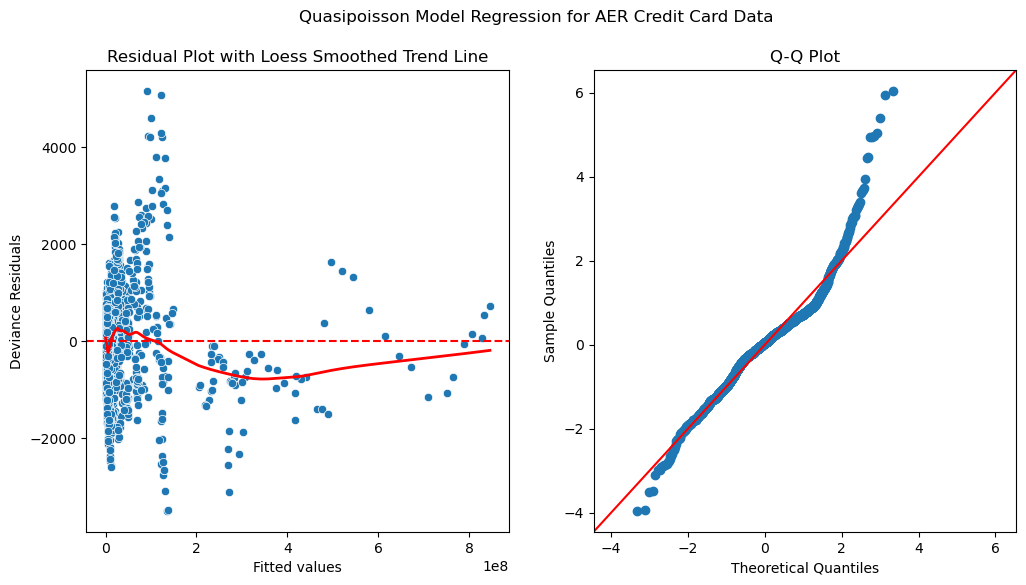

In [210]:


# Deviance residuals
deviance_residuals = qp_model.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Add an overall title
plt.suptitle('Quasipoisson Model Regression for AER Credit Card Data')

# Residual plot
sns.scatterplot(x=qp_model.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, qp_model.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

#plt.tight_layout()

plt.show()

The residual plots show overdispersion and heteroscedasticity. Negative binomial might be a better approach. For the Negative binomial Model, alpha is calculated using MLE approach from quasipoisson model using R.

In [211]:

formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP '

model_nb = smf.glm(
    formula=formula,
    data=train_data,  # your cleaned dataframe
    family=sm.families.NegativeBinomial(alpha=2.43)
).fit()

result_nb = model_nb
print(result_nb.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:       Urban_population   No. Observations:                 2271
Model:                            GLM   Df Residuals:                     2259
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39015.
Date:                Wed, 21 May 2025   Deviance:                       82.635
Time:                        02:53:08   Pearson chi2:                     71.8
No. Iterations:                    26   Pseudo R-squ. (CS):             0.6862
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------



Intercept (exp(-0.9069) = 0.4049): The baseline expected urban population. It is not statistically significant (P = 0.219).

Per Capita GNI (exp(-0.7498) = 0.4721): A 1-unit increase in Per Capita GNI is associated with a 52.79% decrease in the expected urban population. This is a significant negative relationship (P = 0.000), meaning that wealthier countries tend to have a lower urban population growth rate.

Mining and Manufacturing Sector (exp(0.1836) = 1.2012): A 1-unit increase in mining and manufacturing sector activity is associated with a 20.12% increase in the expected urban population. This is a significant positive relationship (P = 0.041), suggesting that countries with more activity in mining and manufacturing tend to have higher urban population growth.

Transport, Storage, and Communication (exp(0.2557) = 1.2912): A 1-unit increase in the transport, storage, and communication sector is associated with a 29.12% increase in the expected urban population. This is a significant positive relationship (P = 0.017), indicating that countries with more investment or activity in these sectors tend to experience higher urban population growth.

GDP (exp(0.6225) = 1.8647): A 1-unit increase in GDP is associated with a 86.47% increase in the expected urban population. This is a significant positive relationship (P = 0.002), meaning wealthier countries tend to have a larger urban population.

Leader Ideology (leftist) (exp(-0.0432) = 0.9574): The effect of leftist leaders on urban population growth is not statistically significant (P = 0.703). There is no substantial evidence to suggest that having a leftist leader has a meaningful impact on urban population growth.

Leader Ideology (rightist) (exp(-0.0535) = 0.9477): Similarly, the effect of rightist leaders on urban population growth is not statistically significant (P = 0.640). The effect is very small, and we do not observe any significant relationship here.

Democracy (exp(0.0948) = 1.0995): The effect of being a democracy on urban population growth is not statistically significant (P = 0.262), meaning democracies don’t show a strong effect on urban population compared to non-democracies.

Agriculture, Hunting, and Fishing Sector (exp(0.0002) = 1.0002): The effect of this sector is extremely small and not statistically significant (P = 0.998), meaning it has no meaningful impact on urban population growth.

Construction Sector (exp(-0.0017) = 0.9983): The effect of the construction sector is very small and not statistically significant (P = 0.982), indicating that this sector does not have a meaningful relationship with urban population growth in the model.

Imports of Goods and Services (exp(-0.1053) = 0.8994): This effect is not statistically significant (P = 0.222), so there is no clear evidence that an increase in imports is linked to urban population growth.

Military Expenditure (exp(0.1170) = 1.1238): While the coefficient is positive, the effect of military expenditure on urban population growth is not statistically significant (P = 0.189).

Summary: Wealthier countries (higher GDP and GNI) tend to experience slower urban population growth (especially with higher GNI), while countries with more activity in the mining, manufacturing, and transport sectors tend to see higher urban population growth.


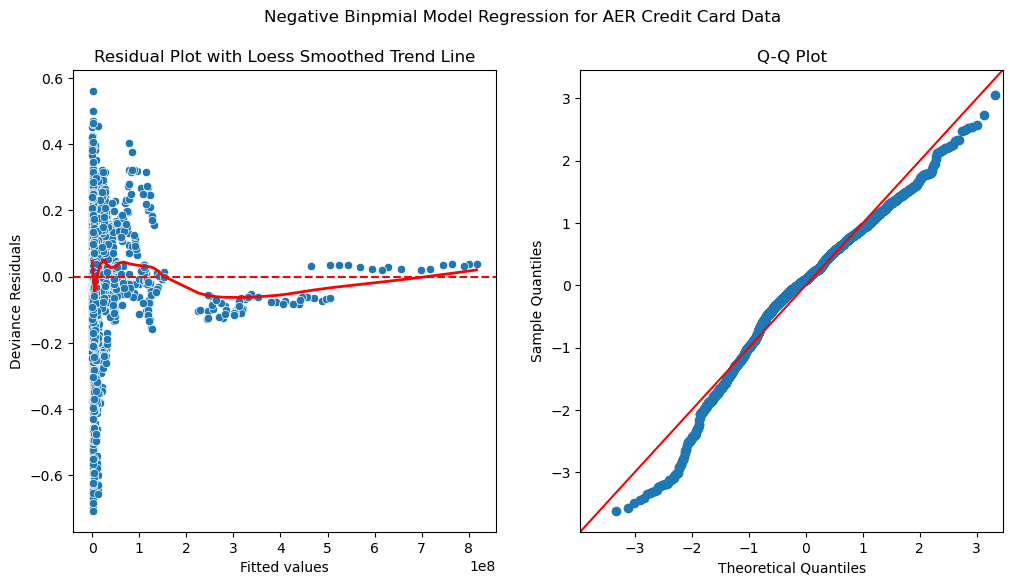

In [212]:


# Deviance residuals
deviance_residuals = model_nb.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Add an overall title
plt.suptitle('Negative Binpmial Model Regression for AER Credit Card Data')

# Residual plot
sns.scatterplot(x=model_nb.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, model_nb.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

#plt.tight_layout()

plt.show()

Negative binomial model seems to be a good fit. QQplot is close to being flat and fitted vs residuals dispersed randomly around 0 (Fitted value scale is 1e8)

### 5.3 GAM Models


# 🚩
### 5.5 SVM Models


We trained a **Support Vector Machine (SVM)** classifier with an RBF kernel to capture non-linear decision boundaries between different political ideologies (leftist, rightist, centrist). Since SVMs naturally handle binary classification, we used a one-vs-one strategy for handling multiple classes. To boost performance and avoid overfitting, we used grid search with cross-validation to tune key hyperparameters like C and gamma.



In [213]:
from sklearn.preprocessing import LabelEncoder

# Select X and y
X = df_log[[
    'Per_capita_GNI',
    'agriculture_and_hunting_fishing_isic',
    'construction_isic',
    'Imports_of_goods_and_services',
    'mining_manifacturing_isic',
    'transport_storage_communication_isic',
    'military_expenditure',
    'GDP',
    'democracy'
]]

y = df_log['leader_ideology']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# SVMs are sensitive to the scale of the features, so we need to standardize them (mean=0, std=1):
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split Train and Test Sets: Stratified split ensures the class distribution remains consistent in both train and test sets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
# We’ll use the RBF kernel , which is effective for non-linear boundaries:
from sklearn.svm import SVC

# Initialize SVM with RBF kernel
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Fit model
svm.fit(X_train, y_train)

ValueError: could not convert string to float: 'no'

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on test set
y_pred = svm.predict(X_test)

# Compute accuracy
acc = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {acc:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Print precision, recall, F1-score per class
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)


Initially, our SVM model had a **test accuracy of 58%**, showing moderate performance but noticeable issues with class imbalance—especially for the minority centrist class, which had a **low recall of 0.05**. The model did okay with the majority classes (leftist and rightist), but there was definitely room for improvement.

#### We try to improve performance by tuning hyperparameters like C and gamma:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_svm = grid.best_estimator_

Then re-evaluate using the best model.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Step 1: Train a new SVM model with best parameters
best_svm = SVC(C=10, gamma=1, kernel='rbf', probability=True, random_state=42)
best_svm.fit(X_train, y_train)

# Step 2: Make predictions
y_pred_best = best_svm.predict(X_test)

# Step 3: Evaluate performance
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy with best model: {acc_best:.4f}")

# Step 4: Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best SVM Model")
plt.xticks(rotation=45)
plt.show()

# Step 5: Classification Report
report_best = classification_report(y_test, y_pred_best, target_names=le.classes_)
print("\nClassification Report (Best SVM Model):")
print(report_best)

### Tuned SVM
**After tuning the hyperparameters using grid search**, the best SVM model's performance shot up, hitting a test accuracy of 85%. The classification report showed big improvements across all metrics:

Precision, recall, and F1-score all increased significantly for all three classes. **The centrist class saw a huge boost in recall (from 0.05 to 0.60) and precision (from 1.00 to 0.85). The leftist and rightist classes also performed well, with F1-scores of 0.88 and 0.85, respectively**. These results indicate that our fine-tuned SVM model successfully learned the complex relationships between economic indicators and political ideology, especially improving its ability to identify the rare centrist cases. This suggests that with proper feature engineering and hyperparameter tuning, SVM can be a powerful tool for predicting ideological leanings based on macroeconomic data.

### 5.4 Neural Networks

**Neural Network**:

## 6. Results
We'll use cross-validation to check our models:

## 7. Reflection on Generative AI
We use generative AI to help us write code, clarify methods, brainstorm, and interpret results. It was quick, but we faced several problems, especially when loading our data sets to draw conclusions. One of our data sets includes ideology information, and some generative AI tools are restricted and can't read such data. For example, **DeepSeek** didn't allow us to load the data set for conclusions. We tried **Perplexity AI**, but its conclusions were inaccurate. **Google Gemini** also failed because it couldn't load a CSV database.

So, we mainly used **OpenAI** and **ChatGPT**. With the free version, it is not possible to have full capacity for drawing conclusions from databases, but it helps clarify methods, brainstorm ideas, and understand correlations. Our hypothesis is complex, involving a social experiment comparing economic indicators and military investment to predict political ideologies. Drawing conclusions from such experiments is hard, but it was an interesting experience.


## 8. Conclusions
From our analysis, we've seen that economic indicators can help predict political ideologies, but not perfectly. Features like GDP, income levels, and military spending were important predictors. This analysis gives useful insights into how economics might influence politics globally.
